<a href="https://colab.research.google.com/github/dominikjagoda/portfolio/blob/main/shooting_MDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Strzelanie z armaty. 
Wejście: obrazek 64x64 piksele pokazujący kierunke lufy działa. 
Wyjście: miejsce trafienia. Jest ono rozmyte funkcją Gaussa.

Na obecnym etapie sieć konwolucyjna znajduje na podstawie rysunku kierunek strzału i przewiduje najbardziej prawdopodobny punkt trafienia. 


In [ ]:
# Install mdn
!pip install keras-mdn-layer


from tensorflow.compat.v1 import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# import mdn
 
import numpy as np
import random
import matplotlib.pyplot as plt

import mdn


## Generate Synthetic Data

Data generation

In [ ]:
PLOT_WIDTH = 64
PLOT_DIM = (PLOT_WIDTH,PLOT_WIDTH)
MAX_ANGLE = 0.4

def generate_data(NSAMPLE=3000, scale=1., rotation_range=0.3, rotation=0):
# NSAMPLE - number of shoots
# scale - smearing of each gaussian
# rotation-range - cannon can rotate in this range
# rotation - center of the rotation range

  # shooting angle
  tan_angle = np.float32(np.random.uniform(rotation - rotation_range, rotation + rotation_range, NSAMPLE))
  

  # target shooting
  length = 30.
  
  half_sample = int(NSAMPLE/2)

  # Here the two-gaussian distribution is produced 
  # here we can produce two-gaussians distribution
  rand1 = np.random.normal(loc=  1, scale=scale, size=half_sample)
  rand2 = np.random.normal(loc=  -1, scale=scale, size=NSAMPLE-half_sample)
  random = np.concatenate((rand1,rand2), axis=0)
  y_data = tan_angle*length + random


  # generate events
  x_data=np.zeros((NSAMPLE,PLOT_DIM[0],PLOT_DIM[1],1))

  x = np.arange(start=0, stop=PLOT_WIDTH, step=1.)
  y = npy = tan_angle * x[ :, np.newaxis]+PLOT_WIDTH/2

  for i in range(NSAMPLE):
    for j in range(2,PLOT_WIDTH-2):
      x_data[i,int(y[j,i]),j] = 1.

  # normalize y_data
  y_data = y_data/(MAX_ANGLE*length)
  x_data = x_data.reshape(NSAMPLE,PLOT_WIDTH,PLOT_WIDTH,1)

  # plot the generated distribution
  #plt.hist(y_data, density=True, bins=30,  alpha=0.5, label='train data') 
  #plt.show()

  return x_data, y_data





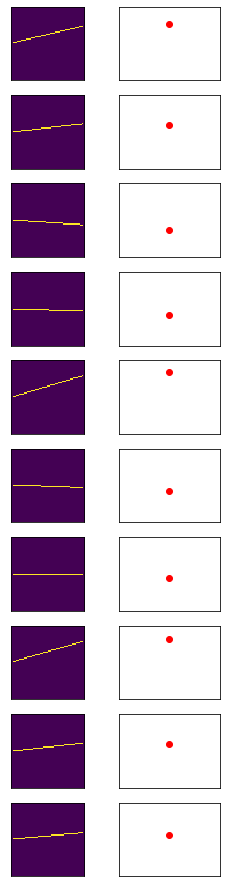

In [ ]:
## Generating some data:
NSAMPLE = 10000
SCALE = 0.2

x_data, y_data = generate_data(NSAMPLE=NSAMPLE, scale=SCALE, rotation_range=0.3, rotation=0)

fig = plt.figure(figsize=(4, 16))

# plot first ten events
for n in range(10):
  ax = fig.add_subplot(10, 2, 2*n + 1, xticks=[], yticks=[])
  ax.imshow(x_data[n].reshape(PLOT_WIDTH,PLOT_WIDTH), interpolation='nearest')
  ax = fig.add_subplot(10, 2, 2*n + 2, xticks=[], yticks=[])
  ax.plot([0],[-y_data[n]], 'ro',)
  plt.ylim([-1, 1])
  plt.xlim([-1, 1])

plt.show()


In [ ]:
N_HIDDEN = 128
N_MIXES = 2  #5

print(x_data.shape)

model = keras.Sequential()

# convolutional network
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(PLOT_WIDTH,PLOT_WIDTH,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dense(N_HIDDEN, activation='relu'))



'''
# fully connected network
model.add(Flatten(batch_input_shape=(None, PLOT_WIDTH*PLOT_WIDTH,1)) )
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(N_HIDDEN, activation='relu'))
'''
# last layer with single node to return the hit position
# model.add(keras.layers.Dense(1))
model.add(mdn.MDN(1, N_MIXES))

# RMSprop() optimizer is used (adam was slightly unstable)
# Dla MDN można użyć i potem rysować  metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)]
model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=keras.optimizers.RMSprop(), metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)] )
model.summary()

(10000, 64, 64, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1

### Training the model

Now we train the model using Keras' normal `fit` command.

In [ ]:
# Dla MDN liczba epochs powinna być większa, np. 100
# history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=20, validation_split=0.2)

history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=40, validation_split=0.15)

Epoch 1/40
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
67/67 [==============================] - 12s 108ms/step - loss: 1.5081 - mse_func: 0.5450 - val_loss: 0.0100 - val_mse_func: 0.2013
Epoch 2/40
67/67 [==============================] - 6s 83ms/step - loss: -0.0136 - mse_func: 0.1638 - val_loss: 0.0967 - val_mse_func: 0.1928
Epoch 3/40
67/67 [==============================] - 6s 83ms/step - loss: -0.3051 - mse_func: 0.0824 - val_loss: -0.3320 - val_mse_func: 0.0492
Epoch 4/40
67/67 [==============================] - 6s 83ms/step - loss: -0.5315 - mse_func: 0.0476 - val_loss: -0.5826 - val_mse_func: 0.0316
Epoch 5/40
67/67 [==============================] - 6s 84ms/step - loss: -0.6965 - mse_func: 0.0347 - val_loss: -0.1202 - val_mse_func: 0.0301
Epoch 6/40
67/67 [==============================] - 6s 83ms/step - loss: -0.6503 - mse_func: 0.0369 - val_loss: -0.1520 - val_mse_func: 0.0827
Epoch 7/40
67/67 [==============================] - 6s 8

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point training is rather slow.



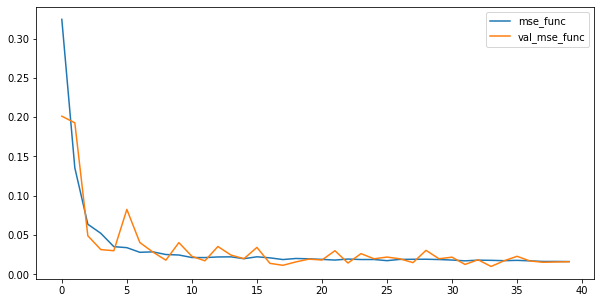

In [ ]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,0.02])
plt.plot(history.history['mse_func'], label='mse_func' )
plt.plot(history.history['val_mse_func'], label='val_mse_func' )
plt.legend(loc='upper right')
plt.show()

In [ ]:
# generate test data

# the whole range of data (identical with the training sample)
x_test, y_test = generate_data(NSAMPLE=NSAMPLE, scale=SCALE, rotation_range=0.3, rotation = 0.0)
# just one shooting position
#x_test, y_test = generate_data(NSAMPLE=NSAMPLE, scale=SCALE, rotation_range=0.01, rotation = 0.2)

In [ ]:
## Sample on some test data:


# Make predictions from the model
y_pred = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Sample from the predicted distributions
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_pred, 1, N_MIXES,temp=1.0)
print(y_samples.shape)


# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_pred)
print(mus.shape)
sigs = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[2*N_MIXES:])),1, y_pred)


(10000, 1, 1)
(10000, 2)


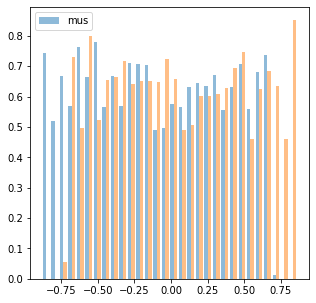

In [ ]:

# Tu można narysować rozkłady parametrów rozkładów Gaussa użytych do aproksymacji prawdopodobieństwa

plt.figure(figsize=(5, 5))
plt.hist(mus, density=True, bins=30,  alpha=0.5, label='mus')
#plt.hist(pis, density=True, bins=30,  alpha=0.5, label='pis')
plt.legend()
plt.show()

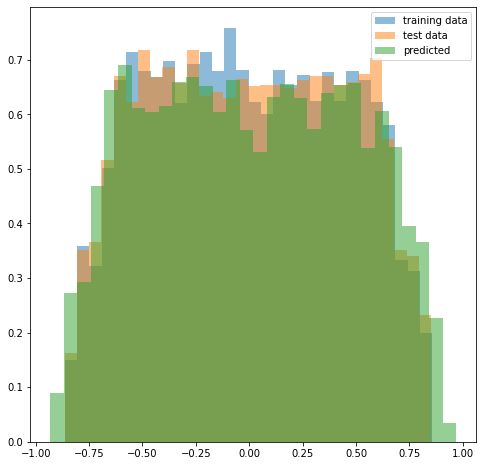

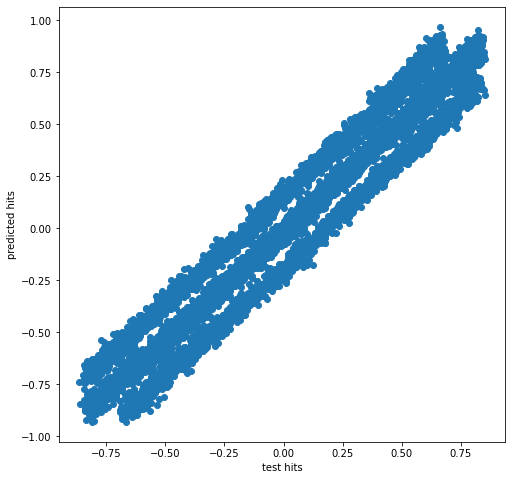

In [ ]:

# Plot the samples
plt.figure(figsize=(8, 8))
plt.hist(y_data.reshape(NSAMPLE,1), density=True, bins=30,  alpha=0.5, label='training data') 
plt.hist(y_test.reshape(NSAMPLE,1), density=True, bins=30,  alpha=0.5, label='test data')
plt.hist(y_samples.reshape(NSAMPLE,1), density=True, bins=30,  alpha=0.5, label='predicted')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_samples)
plt.xlabel("test hits")
plt.ylabel("predicted hits")

plt.show()